# BMW Used Car Price Prediction

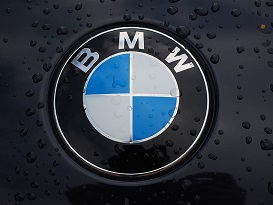

# Importing some libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn import model_selection
from sklearn import linear_model
from sklearn import tree
from sklearn import ensemble
from sklearn import metrics

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

# Importing Data

In [ ]:
df = pd.read_csv('../input/used-car-dataset-ford-and-mercedes/bmw.csv')
df.head()

# Exploring Data

In [ ]:
df.info()

In [ ]:
df.describe()

In [ ]:
sns.heatmap(df.corr(),annot=True, cmap='Blues')

In [ ]:
sns.pairplot(df, diag_kind='kde',
             hue='transmission')

# Visualization / Feature Engineering

To prevent data leakage, we split the dataset into train and test set before implementing feature engineering methods.

In [ ]:
# df_train, df_test = model_selection.train_test_split(df, test_size=0.1, random_state=42)

df_train = df.sample(frac=0.85, random_state=42)
df_test = df.drop(df_train.index, axis=0)

In [ ]:
df_test

## Price

In [ ]:
fig,ax = plt.subplots(nrows=2, ncols=1,
                      sharex=True,
                      gridspec_kw={"height_ratios": (0.75, 0.15)})

sns.histplot(data=df_train, x='price', ax=ax[0], kde=True)

sns.boxplot(data=df_train, x='price', ax=ax[1])
ax[0].set(xlabel='')

plt.tight_layout()

print(f'mean: {df_train.price.mean():.1f}')
print(f'std: {df_train.price.std():.1f}')
print(f'Skewness: {df_train.price.skew():.5f}')
print(f'Kurtosis: {df_train.price.kurt():.5f}\n')

* As can be seen, we have a right-skewed distribution for Price.
* There are some very pricey cars in this dataset. This gives us the suspicious feeling of having some outliers. So, let's delve deeper and list the most expensive cars in the dataset.

In [ ]:
df_train.sort_values(by='price', ascending=False).head(10)

* Except from the first car, we can see they all are new cars with low mile on the clock. No suprise if they cost as a brand-new car.
* However, the first car of this list doesn't follow this pattern. So let's see why this car is far more expensive than others. Maybe it has something to do with the model.

Let's see the price boxplot for "2 Series" model

In [ ]:
df_train[df_train.model==' 2 Series'].price.plot.box()

* Interesting! There is a noticeable difference between that specific car and the other cars.

In [ ]:
df_train[df_train.model==' 2 Series'].sort_values(by='price', ascending=False).head()

* By comparing the first 5 cars in this particular model, we can see car No. 3638 is not even as good as other 4 cars in the specified features.
* This difference could be related to having very special customizations which are not reflected in our features in this dataset.
* Lastly, the "123456" in order as a car price seems a bit odd!!

Thus, we are going to consider this car as an outlier and remove it from the dataset.

In [ ]:
idx_to_remove = df_train[df_train.price==df_train.price.max()].index
df_train.drop(idx_to_remove, inplace= True)

In [ ]:
fig,ax = plt.subplots(nrows=2, ncols=1,
                      sharex=True,
                      gridspec_kw={"height_ratios": (0.75, 0.15)})

sns.histplot(data=df_train, x='price', ax=ax[0], kde=True)

sns.boxplot(data=df_train, x='price', ax=ax[1])
ax[0].set(xlabel='')

plt.tight_layout()

print(f'mean: {df_train.price.mean():.1f}')
print(f'std: {df_train.price.std():.1f}')
print(f'Skewness: {df_train.price.skew():.5f}')
print(f'Kurtosis: {df_train.price.kurt():.5f}\n')

## fuelType

In [ ]:
sns.histplot(data=df_train,
             x='price', hue='fuelType',
             fill=False, element='step')

In [ ]:
df_train.groupby('fuelType').mean()

In [ ]:
sns.pointplot(data=df_train,
             y='price',
             x='fuelType')

In [ ]:
df_train.fuelType.value_counts()

* There are only 3 obervations for Electric cars. For simplicity, we merge "Electric" to the "Other" category.

In [ ]:
### For train set
df_train['fuelType'] = df_train['fuelType'].replace({'Electric':'Other'})

### For test set
df_test['fuelType'] = df_test['fuelType'].replace({'Electric':'Other'})

df_train.fuelType.value_counts()

## transmission

In [ ]:
df_train['transmission'].value_counts()

In [ ]:
sns.countplot(data=df_train, x='transmission',
              order=['Semi-Auto','Automatic','Manual'],
             palette='Blues_r')
plt.show()

In [ ]:
plt.figure(figsize=(7,7),dpi=100)

sns.jointplot(data=df_train,
              x='mileage', y='price',
              hue='transmission',
              alpha=0.7, linewidth=1)
plt.show()

In [ ]:
sns.violinplot(data=df_train,
               y='price', x='transmission',
               inner="quartile")

In [ ]:
### Comparing mean price for each category
sns.pointplot(data=df_train,
              y='price', x='transmission',)

## Model

Number of cars for each category

In [ ]:
df_train['model'].value_counts().plot.bar()

In [ ]:
# Price range based on car models
plt.figure(figsize=(12,5))
sns.boxplot(data=df_train,
            x='model', y='price',
            order=df_train['model'].value_counts().index,
            palette='viridis',)
plt.xticks(rotation=90)
plt.show()

## Year

In [ ]:
df_train.head(3)

In [ ]:
df_train.year.value_counts().plot.bar()

In [ ]:
# Year vs Price
plt.figure(figsize=(12,5))
sns.boxplot(data=df_train,
            x='year', y='price',
            palette='viridis',)
plt.xticks(rotation=90)
plt.show()

In [ ]:
sns.scatterplot(data=df_train,
                x='year', y='mpg', hue='tax',
                palette='rocket_r')

plt.ylim((0,200));

## engineSize

In [ ]:
# Year vs Price
plt.figure(figsize=(12,5))
sns.boxplot(data=df_train,
            x='engineSize', y='price',
            palette='viridis',)
plt.xticks(rotation=90)
plt.show()

## mileage

In [ ]:
# Mileage vs Price
sns.jointplot(data=df_train,
              x='mileage', y='price',
              kind='hist')

# Categorical Feature Encoding

In [ ]:
df_train.info()

There are three categorical variables in this dataset:
* model
* transmission
* tax


# Categorical Encoding

#### We will be using Ordered Label Encoding method to encode the categorical variables. This method:
* Replaces categories with integers based on the target mean.
* Establishes a monotonic relationship between features and target.
* Makes the dataset simple and interpretable, as it doesn't expand the feature space.

In [ ]:
# Categorical features
cat_col = df_train.select_dtypes(include='object')

for col in cat_col:
    
    # Calculating mean for each category
    mean_cat_price = df_train.groupby(col).mean()

    # Sorting the series based on the price
    ordered_col = mean_cat_price.sort_values(by='price')

    # Creating a dictionary based on the ordered list
    mapping_dict = {cat:i for (i,cat) in enumerate(ordered_col.index)}
    
    # Encoding train and test sets
    df_train[col] = df_train[col].map(mapping_dict)
    df_test[col] = df_test[col].map(mapping_dict)

# Modelling

In [ ]:
# Splitting into X and y
X_train = df_train.drop('price', axis=1)
y_train = df_train.price

X_test = df_test.drop('price', axis=1)
y_test = df_test.price

# Model Comparison
comp_dict = {}

In [ ]:
# Scaling features
scaler = preprocessing.StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

## Decision Tree Regressor

In [ ]:
model = tree.DecisionTreeRegressor(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
r2 = metrics.r2_score(y_pred, y_test)

comp_dict['DecisionTree'] = r2
print(f'DecisionTree r2-score: {r2:0.5f}')

## Random Forest Regressor

In [ ]:
model = ensemble.RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
r2 = metrics.r2_score(y_pred, y_test)

comp_dict['RandomForest'] = r2
print(f'RandomForest r2-score: {r2:0.5f}')

## Gradient Boosting Regressor

In [ ]:
model = ensemble.GradientBoostingRegressor(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
r2 = metrics.r2_score(y_pred, y_test)

comp_dict['GradientBoost'] = r2
print(f'GradientBoost r2-score: {r2:0.5f}')

## LightGBM Regressor

In [ ]:
model = LGBMRegressor(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
r2 = metrics.r2_score(y_pred, y_test)

comp_dict['LGBM'] = r2
print(f'LGBM r2-score: {r2:0.5f}')

## CatBoost Regressor

In [ ]:
model = CatBoostRegressor(verbose=0, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
r2 = metrics.r2_score(y_pred, y_test)

comp_dict['CatBoost'] = r2
print(f'CatBoost r2-score: {r2:0.5f}')

## XGBoost Regressor

In [ ]:
model = XGBRegressor(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
r2 = metrics.r2_score(y_pred, y_test)

comp_dict['XGBoost'] = r2
print(f'XGBoost r2-score: {r2:0.5f}')

In [ ]:
pd.DataFrame(comp_dict.items(), columns=['Estimator', 'r2-score']).sort_values(by='r2-score', ascending=False).style.background_gradient()

* We can see the default version of CatBoostRegressor model performs slightly better than the other estimators. However, by tuning hyperparameters, we may end up with a different ranking.